# Profiling tiling of titiler-pgstac and titiler-xarray

This notebook profiles code for tiling CMIP6 data via 2 methods:

1. pgSTAC + COGs: The first method uses a (local) pgSTAC database for storing metadata about COGs on S3. The libraries used are pgstac for reading STAC metadata and rio_tiler's rasterio for reading COGs on S3.
2. kerchunk + netCDF: The second method uses a (local) kerchunk reference file for NetCDF files stored on S3. The libraries used are xarray for reading the Zarr metadata and rio_tiler's XarrayReader for reading data from the NetCDFs on S3.

In the future, the following improvements and additions to this profiling code will be made:

1. Test with a Zarr store. The profiling code will be run on a Zarr store to compare the performance of reading from a Zarr store vs. reading from a NetCDF via kerchunk.
2. Test different chunking strategies: The profiling code will be run on a few different Zarr stores with different chunking schemes.
3. Test a higher resolution dataset.

In [1]:
import io
from PIL import Image
import os

os.environ['GDAL_INGESTED_BYTES_AT_OPEN'] = '32768'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES'] = 'YES'
os.environ['GDAL_HTTP_MULTIPLEX'] = 'YES'
os.environ['GDAL_HTTP_VERSION'] = '2'
os.environ['VSI_CACHE'] = 'TRUE'

In [2]:
xyz_tile = (0,0,0)

## Profile titiler-pgstac

In [3]:
%load_ext autoreload
%autoreload
os.environ['STACK_NAME'] = 'eodc-dev-pgSTAC'
import pgstac.profile_pgstac as profile_pgstac 

<psycopg_pool.pool.ConnectionPool 'pool-1' at 0x1294bdd30>


In [4]:
temporal_resolution = 'daily' # 'monthly'
if temporal_resolution == 'daily':
    collection = "CMIP6_daily_GISS-E2-1-G_TAS"
elif temporal_resolution == 'monthly':
    collection = "CMIP6_ensemble_monthly_median_TAS"
query = {
  "collections": [ collection ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z"           
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

image_and_assets, cprofile = profile_pgstac.tile(*xyz_tile, query=dict(query))
cprofile

time in rasterio.open: 457.76
time initiating WarpedVRT: 1.57
time reading WarpedVRT: 203.11
time creating ImageData: 0.02
time in rasterio.io.reader#part: 220.2
time in MultiBaseReader#tile.tile: 224.86
{'pgstac-search': 96.55, 'get_tile': [719.98], 'mosaic': 722.58}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "        9    0.720    0.080    0.720    0.080 {method 'acquire' of '_thread.lock' objects}",
  '        4    0.178    0.045    0.182    0.045 connection.py:949(wait)',
  '        8    0.001    0.000    0.001    0.000 connection.py:434(_exec_command)',
  '        2    0.001    0.000    0.001    0.000 _queries.py:82(dump)',
  '        1    0.001    0.001    0.907    0.907 profile_pgstac.py:146(tile)',
  '        2    0.001    0.000    0.001    0.000 core.py:3433(__setmask__)']}

**NOTES:**

* There are 2 parts to the overall timing of generating the image - `pgstac-search` and `get_tile`.
* `get_tile` above is a list with a timing for each tif. The bulk of this time is in `CustomSTACReader#tile`. That function has a subfunction `_reader` which wraps `src_dst.tile` in `self.reader`.
* The `CustomSTACReader`'s `reader` attribute is `BaseReader` from `rio_tiler.io.base`. There is no init function for BaseReader so I don't think any time is spent initializing the reader.
* `CustomSTACReader` inherits from `MultiBaseReader` so the `#tile` function is defined in that class.
* The `MultiBaseReader#tile` function also has a `_reader` subfunction which is called for each asset.
* The code for rio_tiler's `MultiBaseReader#tile#_reader` can be thought of as a **initialize reader** step and a **tile** step. 
* The bulk of the `get_tile` time is spent in the **initialize reader** step of `MultiBaseReader#tile#_reader`. The initialization of `MultiBaseReader#reader` spends most of it's time in `rasterio.open`. I have not dug into the subcalls of `rasterio.open`
* `MultiBaseReader#tile#tile` is roughly equivalent to `rasterio.io.reader#part` and wraps the reading of the WarpedVRT, so should be the sum of the previous calls.


/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float64` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


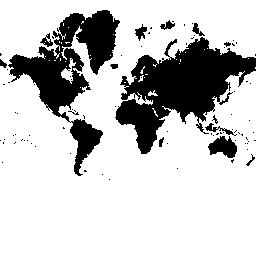

In [5]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-xarray

In [6]:
%load_ext autoreload
%autoreload
import xarray_tile_reader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
os.environ['AWS_PROFILE'] = 'veda-dev'
image_and_assets, cprofile = xarray_tile_reader.tile(
    "cmip6-reference/combined_monthly_cmip6_kerchunk.json", 
    *xyz_tile,
    reference=True,
    anon=False,
    variable="tas",
)
cprofile

Anon is False


/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/zarr_reader.py:41: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xarray.open_dataset(src_path, **xr_open_args)


Time elapsed for xarray.open_datset: 1004.14
Time elapsed for dimension arrangement and array pre-processing: 31.14


TileOutsideBounds: Tile 0/0/0 is outside bounds

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float32` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(
/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:140: RuntimeWarning: invalid value encountered in cast
  return data.astype(out_dtype)


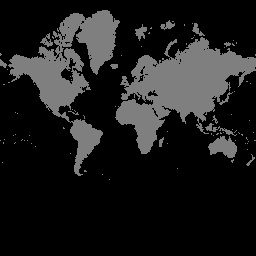

In [12]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im